# Transcrire des images manuscrites

Dans ce guide, nous allons apprendre à générer des séquences de caractères avec l'image en entrée. De plus, nous découvrirons la fonction de perte de CTC, qui aide à transcrire des images manuscrites.

Avant d'en apprendre davantage sur la fonction de perte de CTC, comprenons la raison pour laquelle l'architecture que nous avons vue dans la section de sous-titrage des images peut ne pas s'appliquer à la transcription manuscrite.
 Contrairement au sous-titrage d'image, où il n'y a pas de corrélation directe entre le contenu de l'image et les mots de sortie, dans une image manuscrite, il existe une corrélation directe entre la séquence de caractères présents dans l'image et la séquence de sortie. Ainsi, nous suivrons une architecture différente de celle que nous avons conçue dans la section précédente.

De plus, supposons un scénario où une image est divisée en 20 portions (en supposant un scénario d'un maximum de 20 caractères par mot dans une image), où chaque portion correspond à un caractère. L'écriture d'une personne peut garantir que chaque caractère s'intègre parfaitement dans une case et l'écriture d'une autre peut être mélangée de telle sorte que chaque case contienne deux caractères, et une autre où l'espacement entre deux caractères est si grand qu'il n'est pas possible d'insérer un mot dans 20 pas de temps ( portions). Cela appelle une manière différente de résoudre ce problème, qui tire parti de la fonction de perte CTC - que nous verrons dans la section suivante


## Les détails de fonctionnement de CTC loss

Imaginez un scénario où nous transcrivons une image qui contient le mot ab. L'image peut ressembler à l'une des suivantes et la sortie est toujours ab, quelle que soit l'image que nous choisissons parmi les trois suivantes

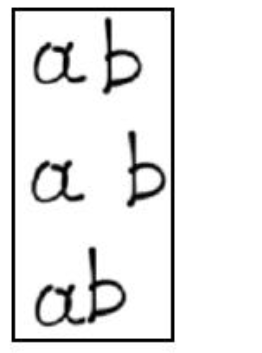

Dans l'étape suivante, nous divisons les trois exemples précédents en six pas de temps, comme suit (où chaque case représente un pas de temps) :

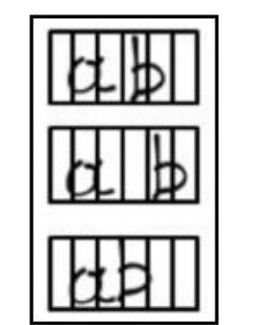

Maintenant, nous allons prédire le caractère de sortie à chaque pas de temps - où la sortie est la softmax des probabilités de mots présents dans un vocabulaire. Étant donné que nous effectuons softmax, disons que le caractère de sortie à chaque pas de temps après avoir passé l'image à travers notre modèle (que nous définirons dans la section suivante) est le suivant (la sortie de chaque cellule est fournie au-dessus de l'image)

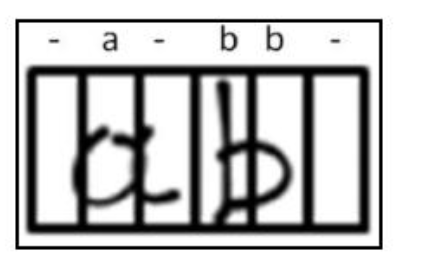

Notez que - représente que rien n'est présent dans le pas de temps correspondant. De plus, notez que le caractère b est répété dans deux pas de temps différents.

Dans la dernière étape, nous allons écraser la sortie (une séquence de caractères) obtenue en passant notre image à travers le modèle de telle sorte que les caractères répétés consécutifs soient écrasés en un seul.

L'étape précédente consistant à écraser la sortie des caractères répétés s'il existe des prédictions consécutives de même caractère donne une sortie finale comme suit :-a-b-

Dans un autre cas, où la sortie est abb, la sortie finale après écrasement devrait avoir un séparateur entre les deux caractères b, dont un exemple est le suivant

-a-b-b-

Maintenant que nous comprenons le concept d'apparence des valeurs d'entrée et de sortie, dans la section suivante, apprenons comment nous calculons la valeur de perte CTC

## Calcul de la valeur de la perte CTC

Pour le problème que nous résolvons dans la section précédente, considérons le scénario suivant - la probabilité d'avoir le character à un pas de temps donné est indiquée dans les cercles du diagramme suivant (notez que les probabilités totalisent 1 à chaque pas de temps de t0 à t5)

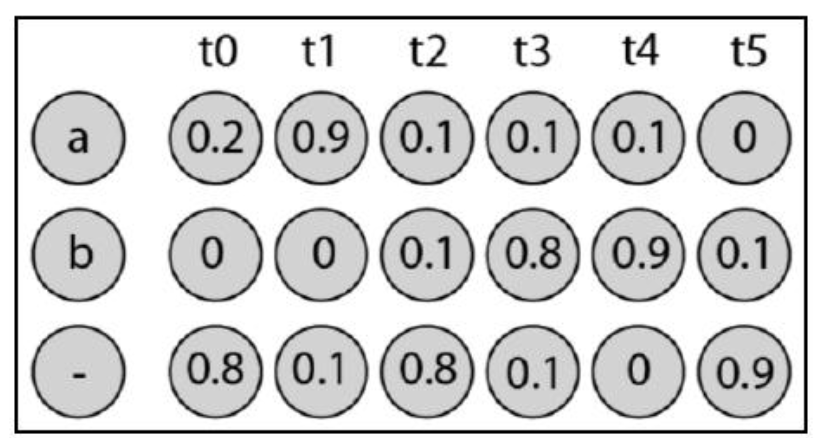

Cependant, pour que le calcul reste simple, pour que nous comprenions comment la valeur de perte CTC est calculée, prenons un scénario où l'image ne contient que le caractère a et non le mot ab. De plus, nous supposerons qu'il n'y a que trois pas de temps pour la simplicité du calcul

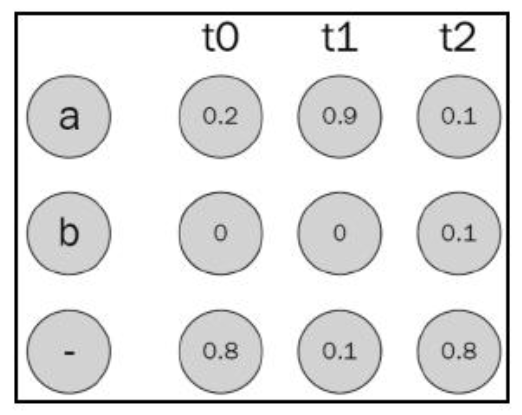

Nous pouvons obtenir la vérité terrain de a si le softmax à chaque pas de temps est comme l'un des sept scénarios suivants

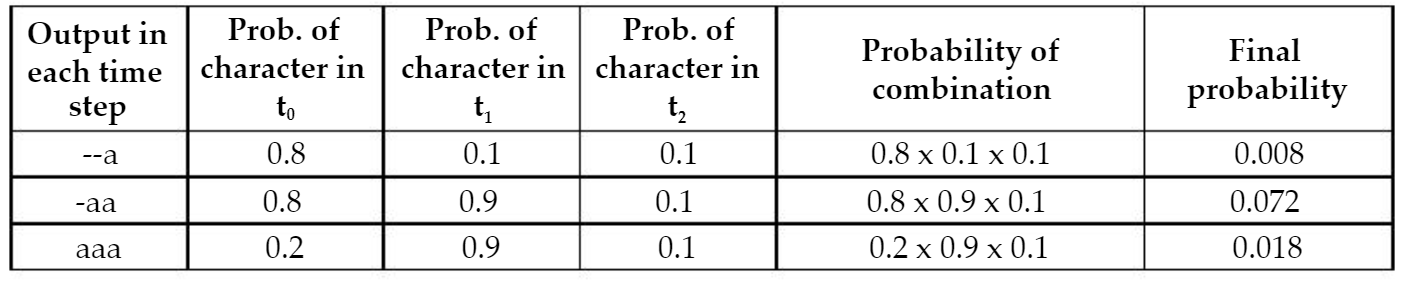
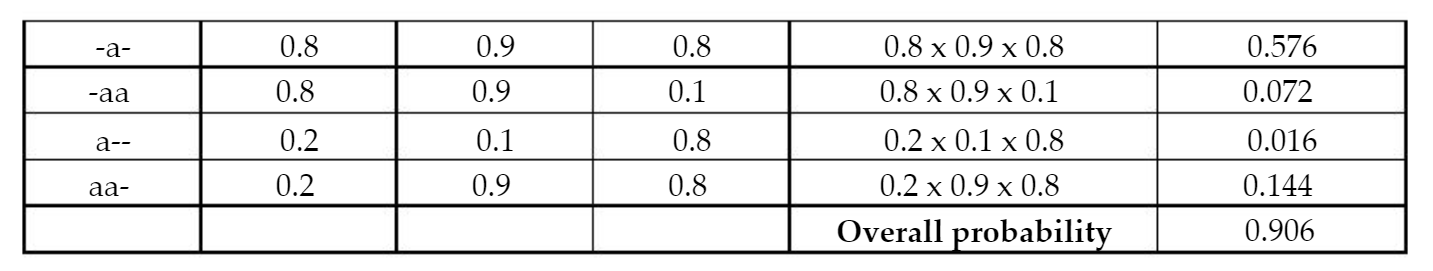

A partir des résultats précédents, nous pouvons voir que la probabilité globale d'obtenir la vérité terrain est de 0,906.

Le reste des 0,094 correspond à la probabilité que le résultat n'obtienne pas la vérité terrain. 

Calculons la perte d'entropie croisée binaire correspondant à la sommation de tous les vérités terrain possibles. 

La perte CTC est le logarithme négatif de la somme globale des probabilités de combinaisons qui donnent une vérité terrain = -log (0,906) = 0,1. 

Maintenant que nous comprenons comment la perte CTC est calculée, mettons en œuvre cette connaissance tout en construisant un modèle pour transcription manuscrite à partir d'une image dans la section suivante

## Transcription de l'écriture manuscrite dans le code

La stratégie que nous adopterons pour coder un réseau capable de transcrire le contenu d'une image d'un mot manuscrit est la suivante : 

* 1. Importer le jeu de données des images et leurs transcriptions correspondantes.
* 2.Donner un index à chaque caractère.
* 3.Passer l'image à travers un réseau convolutif pour récupérer la carte de caractéristiques correspondant à l'image

* 4. Passer les cartes de caractéristiques à travers un RNN.

* 5. Récupérer les probabilités à chaque pas de temps.
* 6. Exploiter la fonction de perte CTC pour écraser les sorties et fournir la transcriptions et la perte correspondante. 
* 7. Les poids du réseau sont optimisés en minimisant la fonction CTC loss

Exécutons la stratégie précédente dans le code

1 . Téléchargez et importez le jeu de données d'images 

In [ ]:
!wget https://www.dropbox.com/s/l2ul3upj7dkv4ou/synthetic-data.zip
!unzip -qq synthetic-data.zip

--2021-10-27 13:59:03--  https://www.dropbox.com/s/l2ul3upj7dkv4ou/synthetic-data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/l2ul3upj7dkv4ou/synthetic-data.zip [following]
--2021-10-27 13:59:03--  https://www.dropbox.com/s/raw/l2ul3upj7dkv4ou/synthetic-data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4587824996dd0b99f5dcb871b7.dl.dropboxusercontent.com/cd/0/inline/BY31LBPU1Fon_C0_yz-RclPfnRx1jiTPLEMKyAmWD7yFbApWj3awy9ECfPrgTp4lYwacMz-a3HSPHP4Kq7wSfB19nen3ydn48t-cjGjTNV2JbZS7IJf8qBDzNMZ5RaQ6mS8W8rmfaCCd21ZxYBe2Kvuu/file# [following]
--2021-10-27 13:59:04--  https://uc4587824996dd0b99f5dcb871b7.dl.dropboxusercontent.com/cd/0/inline/BY31LBPU1Fon_C0_yz-RclPfnRx1jiTPLEMKyAmWD7yFbApWj3awy9ECfPrgTp4lYwacM

Dans le code précédent, nous avons téléchargé l'ensemble de données où les images sont fournies et le nom de fichier de l'image contient la vérité terrain de la transcription correspondant à cette image

2. Installez les packages requis et importez-les

In [ ]:
!pip install torch_snippets torch_summary editdistance

     |████████████████████████████████| 43 kB 750 kB/s 
     |████████████████████████████████| 56 kB 3.5 MB/s 
     |████████████████████████████████| 212 kB 8.3 MB/s 
     |████████████████████████████████| 10.1 MB 27.7 MB/s 
     |████████████████████████████████| 57 kB 5.3 MB/s 
     |████████████████████████████████| 51 kB 6.9 MB/s 


In [ ]:
from torch_snippets import *
from torchsummary import summary
import editdistance

 3. Spécifiez l'emplacement des images et la fonction pour récupérer le ground truth à partir des images :

In [ ]:
from pathlib import Path
device = 'cuda' if torch.cuda.is_available() else 'cpu'
fname2label = lambda fname: stem(fname).split('@')[0]

images = []

for img in Path('/content/synthetic-data').glob("*.png"):
  images.append(img.name)

Notez que nous créons la fonction fname2label car la vérité terrain d'une image est disponible après le symbole @ dans le nom de fichier.

4. Définir le vocabulaire des caractères (vocab), la taille du lot (B), le pas temps du RNN (T), la longueur du vocabulaire (V), la hauteur (H) et la largeur (W) des images

In [ ]:
vocab = 'QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm'
B,T,V = 64, 32, len(vocab) 
H, W = 32, 128

5. Définir la classe de jeu de données OCRDataset

* Définissez la méthode __init__ où nous spécifions le mappage du caractère à l'ID de caractère (charList) et inversement (invCharList) en parcourant le vocabulaire, ainsi que le nombre de pas de temps (timesteps) et les chemins de fichiers des images (items) qui sont être récupéré. Nous utilisons charList et invCharList au lieu d'utiliser le vocabulaire de construction de torchtext ici car le vocabulaire est plus simple à gérer (contient moins de caractères distincts)

* Notez que dans la méthode __getitem__, nous lisons l'image et créons l'étiquette à l'aide de fname2label, que nous avons défini précédemment. De plus, nous définissons un exemple de méthode qui nous aide à échantillonner de manière aléatoire une image à partir de l'ensemble de données.

* Définissez la méthode collate_fn, qui prend un lot d'images et les ajoute ainsi que leurs étiquettes dans différentes listes. De plus, il convertit les caractères de la vérité terrain correspondant à une image dans leur format vectoriel (qui convertit chaque caractère en son ID correspondant) et enfin, stocke la longueur de l'étiquette et la longueur d'entrée (qui est toujours le nombre de pas de temps) pour chaque image. la longueur de l'étiquette et la longueur d'entrée sont exploitées par la fonction de perte CTC lors du calcul de la valeur de perte

* Définir la fonction str2vec, qui convertit une entrée d'ID de caractère en une chaîne
Dans la fonction str2vec, nous récupérons les caractères d'une chaîne d'identifiants de caractères et ajoutons les vecteurs avec un indice de remplissage de 0 si la longueur des étiquettes (len(val)) est inférieure au nombre de pas de temps (self.ts)


* Définissez la fonction de preprocess , qui prend une image (img) et une forme en entrée pour la traiter en une forme cohérente de 32 x 128. Notez qu'un prétraitement supplémentaire doit être effectué autre que le redimensionnement de l'image car les images doivent être redimensionnées tout en maintenant le rapport hauteur/largeur .Définir la fonction de prétraitement et la forme cible de l'image, qui pour l'instant est initialisée comme une image vierge (image blanche – cible) Renvoie l'image normalisée (où nous convertissons d'abord l'image pour avoir un fond noir, puis redimensionnons les pixels à une valeur comprise entre 0 et 1)

* Définir la fonction decoder_chars pour décoder les prédictions en mots, Dans le code précédent, nous parcourons les prédictions (pred) un pas de temps à la fois, en récupérant le caractère qui a la confiance la plus élevée (k), en le comparant avec le personnage qui a la confiance la plus élevée dans le pas de temps précédent (dernier), et en l'ajoutant aux caractères décodés jusqu'à présent si le caractère avec la confiance la plus élevée dans le pas de temps précédent n'est pas le même que le caractère avec la confiance la plus élevée dans le pas de temps actuel (équivalent à l'écrasement, dont nous avons discuté dans la section sur la fonction de perte CTC)

* Définir les méthodes de calcul de la précision des caractères et des mots

* Définir une méthode pour évaluer le modèle sur un ensemble d'images et renvoyer le taux d'erreur sur les mots et les caractères



In [ ]:
class OCRDataset(Dataset):
    def __init__(self, items, vocab=vocab, preprocess_shape=(H,W), timesteps=T):
        super().__init__()
        self.items = items
        self.charList = {ix+1:ch for ix,ch in enumerate(vocab)}
        self.charList.update({0: '`'})
        self.invCharList = {v:k for k,v in self.charList.items()}
        self.ts = timesteps

    def __len__(self):
        return len(self.items)

    def sample(self):
        return self[randint(len(self))]

    def __getitem__(self, ix):
        item = self.items[ix]
        image = cv2.imread('/content/synthetic-data/'+item, 0)
        label = fname2label(item)
        return image, label

    def collate_fn(self, batch):
        images, labels, label_lengths, label_vectors, input_lengths = [], [], [], [], []
        for image, label in batch:
            images.append(torch.Tensor(self.preprocess(image))[None,None])
            label_lengths.append(len(label))
            labels.append(label)
            label_vectors.append(self.str2vec(label))
            input_lengths.append(self.ts)
        images = torch.cat(images).float().to(device)
        label_lengths = torch.Tensor(label_lengths).long().to(device)
        label_vectors = torch.Tensor(label_vectors).long().to(device)
        input_lengths = torch.Tensor(input_lengths).long().to(device)
        return images, label_vectors, label_lengths, input_lengths, labels

    def str2vec(self, string, pad=True):
        string = ''.join([s for s in string if s in self.invCharList])
        val = list(map(lambda x: self.invCharList[x], string)) 
        if pad:
            while len(val) < self.ts:
                val.append(0)
        return val

    def preprocess(self, img, shape=(32, 128)):
        target = np.ones(shape)*255
        try:
            H, W = shape
            h, w = img.shape
            fx = H/h
            fy = W/w
            f = min(fx, fy)
            _h = int(h*f)
            _w = int(w*f)
            _img = cv2.resize(img, (_w, _h))
            target[:_h,:_w] = _img
        except:
            ...
        return (255-target)/255

    def decoder_chars(self, pred):
        decoded = ""
        last = ""
        pred = pred.cpu().detach().numpy()
        for i in range(len(pred)):
            k = np.argmax(pred[i])
            if k > 0 and self.charList[k] != last:
                last = self.charList[k]
                decoded = decoded + last
            elif k > 0 and self.charList[k] == last:
                continue
            else:
                last = ""
        return decoded.replace(" "," ")

    def wer(self, preds, labels):
        c = 0
        for p, l in zip(preds, labels):
            c += p.lower().strip() != l.lower().strip()
        return round(c/len(preds), 4)

    def cer(self, preds, labels):
        c, d = [], []
        for p, l in zip(preds, labels):
            c.append(editdistance.eval(p, l) / len(l))
        return round(np.mean(c), 4)
    def evaluate(self, model, ims, labels, lower=False):
        model.eval()
        preds = model(ims).permute(1,0,2) # B, T, V+1
        preds = [self.decoder_chars(pred) for pred in preds]
        return {'char-error-rate': self.cer(preds, labels),
                'word-error-rate': self.wer(preds, labels),
                'char-accuracy' : 1 - self.cer(preds, labels),
                'word-accuracy' : 1 - self.wer(preds, labels)}

.6 Spécifier les ensembles de données d'entraînement et de validation et les chargeurs de données

In [ ]:
from sklearn.model_selection import train_test_split
trn_items, val_items = train_test_split(images, test_size=0.2, random_state=22)
trn_ds = OCRDataset(trn_items)
val_ds = OCRDataset(val_items)

trn_dl = DataLoader(trn_ds, batch_size=B, collate_fn=trn_ds.collate_fn, drop_last=True, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=B, collate_fn=val_ds.collate_fn, drop_last=True)

7. Construire l'architecture du réseau

* Construire les blocs de base d'un CNN

In [ ]:
from torch_snippets import Reshape, Permute

class BasicBlock(nn.Module):
    def __init__(self, ni, no, ks=3, st=1, padding=1, pool=2, drop=0.2):
        super().__init__()
        self.ks = ks
        self.block = nn.Sequential(
            nn.Conv2d(ni, no, kernel_size=ks, stride=st, padding=padding),
            nn.BatchNorm2d(no, momentum=0.3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool),
            nn.Dropout2d(drop)
        )
    def forward(self, x):
        return self.block(x)

* Construisez la classe de réseau neuronal OCR qui a les blocs CNN et les blocs RNN définis dans la méthode __init__ dans self.model et self.rnn, respectivement. Ensuite, nous définissons la self.classificationlayer, qui prend la sortie d'un RNN et la fait passer par une activation softmax après avoir traité la sortie RNN à travers une couche dense

In [ ]:
class Ocr(nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.model = nn.Sequential(
            BasicBlock( 1, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 256, pool=(4,2)),
            Reshape(-1, 256, 32),
            Permute(2, 0, 1) # T, B, D
        )
        self.rnn = nn.Sequential(
            nn.LSTM(256, 256, num_layers=2, dropout=0.2, bidirectional=True),
        )
        self.classification = nn.Sequential(
            nn.Linear(512, vocab+1),
            nn.LogSoftmax(-1),
        )
    def forward(self, x):
        x = self.model(x)
        x, lstm_states = self.rnn(x)
        y = self.classification(x)
        return y

In [ ]:
def ctc(log_probs, target, input_lengths, target_lengths, blank=0):
    loss = nn.CTCLoss(blank=blank, zero_infinity=True)
    ctc_loss = loss(log_probs, target, input_lengths, target_lengths)
    return ctc_loss

In [ ]:
model = Ocr(len(vocab)).to(device)
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros((1,1,32,128)).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 1, 256]              --
├─Sequential: 1-2                        [-1, 1, 512]              --
|    └─LSTM: 2-6                         [-1, 1, 512]              2,629,632
├─Sequential: 1-3                        [-1, 1, 53]               --
|    └─Linear: 2-7                       [-1, 1, 53]             

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 1, 256]              --
├─Sequential: 1-2                        [-1, 1, 512]              --
|    └─LSTM: 2-6                         [-1, 1, 512]              2,629,632
├─Sequential: 1-3                        [-1, 1, 53]               --
|    └─Linear: 2-7                       [-1, 1, 53]             

In [ ]:
def train_batch(data, model, optimizer, criterion):
    model.train()
    imgs, targets, label_lens, input_lens, labels = data
    optimizer.zero_grad()
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    loss.backward()
    optimizer.step()
    results = trn_ds.evaluate(model, imgs.to(device), labels)
    return loss, results

In [ ]:
@torch.no_grad()
def validate_batch(data, model):
    model.eval()
    imgs, targets, label_lens, input_lens, labels = data
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    return loss, val_ds.evaluate(model, imgs.to(device), labels)

In [ ]:
model = Ocr(len(vocab)).to(device)
criterion = ctc

optimizer = optim.AdamW(model.parameters(), lr=3e-3)

n_epochs = 50
log = Report(n_epochs)

In [ ]:
for ep in range( n_epochs):
    # if ep in lr_schedule: optimizer = AdamW(ocr.parameters(), lr=lr_schedule[ep])
    N = len(trn_dl)
    for ix, data in enumerate(trn_dl):
        pos = ep + (ix+1)/N
        loss, results = train_batch(data, model, optimizer, criterion)
        # scheduler.step()
        ca, wa = results['char-accuracy'], results['word-accuracy']
        log.record(pos=pos, trn_loss=loss, trn_char_acc=ca, trn_word_acc=wa, end='\r')
    val_results = []
    N = len(val_dl)
    for ix, data in enumerate(val_dl):
        pos = ep + (ix+1)/N
        loss, results = validate_batch(data, model)
        ca, wa = results['char-accuracy'], results['word-accuracy']
        log.record(pos=pos, val_loss=loss, val_char_acc=ca, val_word_acc=wa, end='\r')

    log.report_avgs(ep+1)
    print()
    for jx in range(5):
        img, label = val_ds.sample()
        _img = torch.Tensor(val_ds.preprocess(img)[None,None]).to(device)
        pred = model(_img)[:,0,:]
        pred = trn_ds.decoder_chars(pred)
        print(f'Pred: `{pred}` :: Truth: `{label}`')
    print()

EPOCH: 1.000	trn_loss: 3.315	trn_char_acc: 0.019	trn_word_acc: 0.000	val_loss: 3.068	val_char_acc: 0.142	val_word_acc: 0.000	(157.56s - 7720.23s remaining)

Pred: `te` :: Truth: `road`
Pred: `se` :: Truth: `back`
Pred: `se` :: Truth: `protect`
Pred: `se` :: Truth: `meet`
Pred: `se` :: Truth: `rest`

EPOCH: 2.000	trn_loss: 2.876	trn_char_acc: 0.178	trn_word_acc: 0.001	val_loss: 2.611	val_char_acc: 0.228	val_word_acc: 0.001	(315.26s - 7566.20s remaining)

Pred: `cthe` :: Truth: `check`
Pred: `sie` :: Truth: `yeah`
Pred: `mte` :: Truth: `wonder`
Pred: `lie` :: Truth: `life`
Pred: `e` :: Truth: `move`

EPOCH: 3.000	trn_loss: 2.256	trn_char_acc: 0.372	trn_word_acc: 0.013	val_loss: 1.738	val_char_acc: 0.491	val_word_acc: 0.034	(472.84s - 7407.79s remaining)

Pred: `larce` :: Truth: `large`
Pred: `coat` :: Truth: `foot`
Pred: `ht` :: Truth: `his`
Pred: `tet` :: Truth: `light`
Pred: `mint` :: Truth: `mind`

EPOCH: 4.000	trn_loss: 1.546	trn_char_acc: 0.606	trn_word_acc: 0.111	val_loss: 1.178	va

100%|██████████| 151/151 [00:00<00:00, 173.07it/s]


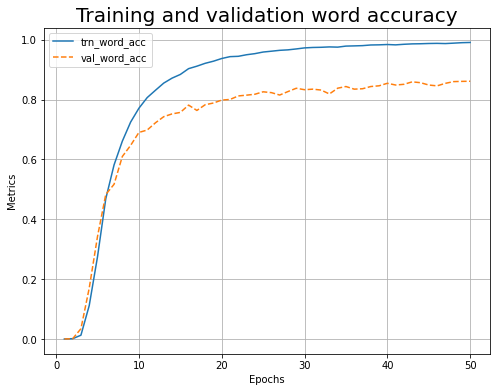

In [ ]:
log.plot_epochs(['trn_word_acc','val_word_acc'], title='Training and validation word accuracy')